## Importar lo importante

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime as dt
import pickle
import numpy as np
import borrador
from __future__ import division
from auxiliar_functions import *
import tfe
from geopy.distance import vincenty
from itertools import chain, combinations
import random
import scipy as sp

## Funciones Auxiliares

In [2]:
#Función que filtra columnas de acuerdo a una lista de indices
#filter_features: matrix list -> matrix
def filter_features(vector,selected_features):
    selected = []
    for i in range(len(selected_features)):
        selected.append(features_dict[selected_features[i]])
    return vector[:,selected]

In [3]:
def only_one_match_home_and_work(limit,shared_rois):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    for i in range(limit):
        neighbours = get_neighbours_index(shared_rois,i,2)
        if len(neighbours) > 0:
            if len(neighbours) == 1:
                a_matrix[i,neighbours[0]] = 0
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [6]:
def random_match_home_and_work(limit,shared_rois):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    for i in range(limit):
        neighbours = get_neighbours_index(shared_rois,i,2)
        n_neighbours = len(neighbours)
        if n_neighbours > 0:
            if n_neighbours == 1:
                a_matrix[i,neighbours[0]] = 0
            else:
                random_neighbour = random.choice(neighbours)
                a_matrix[i,random_neighbour] = 0
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [339]:
def compare_vectors_with_neighbours(vector_a,vector_b,rois_a,rois_b,shared_rois,limit,min_shared,f_normalizar,f_distancia):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    for i in range(limit):
        #print "Usuario ",i
        rois_abril = rois_a[i]
        neighbours = get_neighbours_index(rois_abril,shared_rois,i,min_shared)
        if len(neighbours) > 0:
            if len(neighbours) == 1:
                a_matrix[i,neighbours[0]] = 0
            else:
                a_sequence = vector_a[i,:]
                b_sequences = vector_b[neighbours,:]
                ab_sequences = np.vstack((a_sequence,b_sequences))
                for j in range(ab_sequences.shape[1]):
                    ab_sequences[:,j] = f_normalizar(ab_sequences[:,j])
                counter = 0
                for neighbour in neighbours:
                    dist = f_distancia(np.asarray(ab_sequences[0,:]),np.asarray(ab_sequences[counter+1,:]))
                    a_matrix[i,neighbour] = -dist
                    counter += 1
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [297]:
neighburs = get_neighbours_index(shared_rois,1829,2)
neighburs

array([1829, 2110, 2712, 3271, 4424])

In [298]:
neighburs = get_neighbours_index(shared_rois,1829,2)
i = 1829
a_sequence = abril_selected_features[i,:]
b_sequences = septiembre_selected_features[neighburs,:]
ab_sequences = np.vstack((a_sequence,b_sequences))
for i in range(ab_sequences.shape[1]):
    ab_sequences[:,i] = normalizar(ab_sequences[:,i])
pd.DataFrame(ab_sequences)

0         1         2         3         4         5         6   \
0  0.768005  0.234478  0.107873  0.268945  0.236329  0.184279  0.279562   
1  0.170092  0.256958  0.141095  0.312517  0.822196  0.247446  0.124270   
2  0.000000  0.356958  0.050553  0.115478  0.375303  0.245689  0.270979   
3  0.129063  0.025692  0.878229  0.790451  0.003350  0.772343  0.421315   
4  0.225940  0.000000  0.088745  0.316488  0.000000  0.196454  0.320780   
5  0.631294  0.098044  0.000000  0.000000  0.236841  0.000000  0.000000   

         7         8         9         10        11        12        13   14  \
0  0.135152  0.285714  0.371429  0.518907  0.157296  0.428571  0.333333  0.5   
1  0.000000  0.428571  0.550000  0.134181  0.122713  0.000000  0.000000  0.0   
2  0.171268  0.428571  0.800000  0.273788  0.000000  0.000000  0.333333  0.0   
3  0.262650  0.000000  0.085714  0.122805  0.118542  0.428571  0.000000  0.0   
4  0.171268  0.428571  0.228571  0.326611  0.220585  0.428571  0.333333  1.0   
5  0.000000  0.028571  0.000000  0.000000  0.105401  0.142857  0.333333  0.0   

     15        16  
0  0.00  0.789474  
1  0.00  0.544737  
2  0.25  0.605263  
3  0.00  0.759144  
4  0.00  1.000000  
5  1.00  0.000000

In [299]:
counter = 0
for neighbour in neighburs:
    dist = sp.spatial.distance.euclidean(np.asarray(ab_sequences[0,:]),np.asarray(ab_sequences[counter+1,:]))
    print -dist
    counter += 1

-1.24772003022
-1.21455669278
-1.56121688142
-0.886884446948
-1.63786205831


In [300]:
counter = 0
for neighbour in neighburs:
    dist = abs(np.linalg.norm(np.asarray(ab_sequences[0,:])-np.asarray(ab_sequences[counter+1,:])))
    print -dist
    counter += 1

-1.24772003022
-1.21455669278
-1.56121688142
-0.886884446948
-1.63786205831


In [301]:
counter = 0
for neighbour in neighburs:
    dist = abs(np.linalg.norm(np.asarray(ab_sequences[0,:])-np.asarray(ab_sequences[counter+1,:])))
    print -dist
    counter += 1

-1.24772003022
-1.21455669278
-1.56121688142
-0.886884446948
-1.63786205831


In [302]:
np.vstack((septiembre_vectors[0],septiembre_vectors[[1,2,3,4]])).shape

(5, 19)

In [10]:
def get_n_correct(a_matrix,limit):
    identified_indexs = [] #almacena los indices de que secuencia fue seleccionada como match
    wrong_indexs = [] # almacena los indices de los que se clasificaron incorrectamente
    correct_indexs = [] # almacena los indices de los que se clasificaron correctamente
    selected_distance = [] # almacena la distancia de los seleccionados
    abstenidos = []
    n_identified = 0
    for i in range(limit):
        the_index = np.argmax(a_matrix[:,i])
        selected_distance.append(a_matrix[the_index,i])
        identified_indexs.append(the_index)
        if a_matrix[the_index,i] == -1:
            abstenidos.append(the_index)
        elif(the_index!=i):
            wrong_indexs.append(the_index)
        else:
            correct_indexs.append(the_index)
            n_identified += 1
    return [n_identified,selected_distance,identified_indexs,abstenidos]


In [235]:
#normalizar: [float] -> [float(0,1)]
#Normalizacion mayor menor
def normalizar(vector):
    a_max = np.max(vector)
    a_min = np.min(vector)
    if a_max == 0 and a_min == 0:
        return vector
    #if a_max == 0:
     #   a_max= a_min*0.0000001
    for i in range(len(vector)):
        vector[i] = (vector[i] - a_min)/a_max
    return vector    

In [330]:
#get_neighbours_index: np.matrix int -> np.array
#obtiene los vecinos del usuario "user",
#considerando como vecino a quien comparte dos ubicaciones
def get_neighbours_index(rois_a,shared_rois,user,min_shared):
    min_shared_x = min(len(rois_a),min_shared)
    neighbours = np.where(shared_rois[user] >= min_shared_x)
    return neighbours[0]

## Obtener datos

In [14]:
with open('data/shared_rois.pickle') as f:
    shared_rois = pickle.load(f)

In [36]:
with open('data/Distancia_Euclideana/features.pickle') as f:
    abril_vectors = pickle.load(f)
    septiembre_vectors = pickle.load(f)

In [40]:
with open('data/rois_meters_data.pickle') as f:
    abril_the_rois = pickle.load(f)
    septiembre_the_rois = pickle.load(f)

In [41]:
limit = np.min((len(abril_vectors),len(septiembre_vectors)))
limit

5169

In [327]:
shared_1_rois_2_month = 0
shared_2_rois_2_month = 0
for i in range(limit):
    if shared_rois[i,i] > 0:
        shared_1_rois_2_month += 1
    if shared_rois[i,i] > 1:
        shared_2_rois_2_month += 1
print "% de tarjetas que comparten un roi en ambos meses:",str(round(shared_1_rois_2_month*100/limit,2)) + "%"
print "% de tarjetas que comparten dos roi en ambos meses:", str(round(shared_2_rois_2_month*100/limit,2)) + "%"

% de tarjetas que comparten un roi en ambos meses:  93.38%
% de tarjetas que comparten dos roi en ambos meses:  54.85%


### Histograma cantidad de vecinos de hogar y trabajo (2 rois) entre abril y septiembre

In [73]:
n_of_neighbours = []
for i in range(limit):
    n_of_neighbours.append(len(get_neighbours_index(shared_rois,i,2)))

In [74]:
plt.hist(n_of_neighbours,range(10))

(array([ 1051.,  1642.,   808.,   431.,   263.,   191.,   116.,    91.,
          117.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

### Histograma cantidad de vecinos de hogar y trabajo (2 rois) entre abril y septiembre

In [328]:
n10_of_neighbours = filter(lambda x: x>9,n_of_neighbours)

(array([ 269.,  109.,   36.,    8.,    8.,    8.,    5.,    4.,    1.,
           0.,    0.,    1.,    2.,    1.,    0.,    0.,    0.,    0.,
           1.,    0.,    2.,    0.,    0.,    1.,    1.,    0.,    1.,
           0.,    0.,    1.]),
 array([  10.        ,   19.06666667,   28.13333333,   37.2       ,
          46.26666667,   55.33333333,   64.4       ,   73.46666667,
          82.53333333,   91.6       ,  100.66666667,  109.73333333,
         118.8       ,  127.86666667,  136.93333333,  146.        ,
         155.06666667,  164.13333333,  173.2       ,  182.26666667,
         191.33333333,  200.4       ,  209.46666667,  218.53333333,
         227.6       ,  236.66666667,  245.73333333,  254.8       ,
         263.86666667,  272.93333333,  282.        ]),
 <a list of 30 Patch objects>)

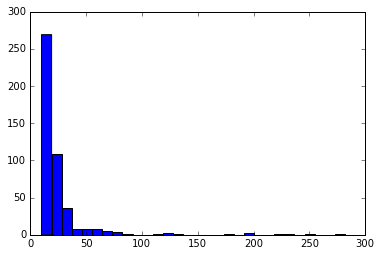

In [329]:
plt.hist(n10_of_neighbours,30)

## Seleccionar Features para la comparación

In [139]:
features_names = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin","card_type",\
    "start_time","end_time","traveled_days","traveled_days_bs","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]

In [140]:
features_dict = {"msal":0,"mlal":1,"kmDistance":2,"kmMaxDist":3,"kmMinDist":4,"rg":5,"unc_entropy":6,
                  "random_entropy":7,"p100_diff_last_origin":8,"p100_diff_first_origin":9,"card_type":10,
                  "start_time":11,"end_time":12,"traveled_days":13,"traveled_days_bs":14,"frequence_regularity":15,
                  "p100_exclusive_bus_days":16,"p100_exclusive_metro_days":17,"P100_bus_trips":18}

In [141]:
selected_features = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin",\
    "start_time","end_time","traveled_days","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]


In [142]:
#selected_features = features_names

In [143]:
len(selected_features)

17

In [144]:
abril_selected_features = filter_features(abril_vectors,selected_features)
septiembre_selected_features = filter_features(septiembre_vectors,selected_features)

## Normalizar con respecto a los vecinos

In [145]:
abril_selected_features.shape

(5169, 17)

## Hacer las comparaciones

### Seleccionar solo los que se tiene un match

In [146]:
a_matrix_unique_match = only_one_match_home_and_work(limit,shared_rois)

0.0594351291656


In [147]:
n_identified_unique_match,selected_distance_unique_match,identified_indexs_unique_match,abstenidos_unique_match = get_n_correct(a_matrix_unique_match,limit)

In [148]:
porcentaje_correcto_unique_match = n_identified_unique_match*100/limit
print str(round(porcentaje_correcto_unique_match,2))+ "%"

21.88%


### Seleccionar randommente entre los vecinos que matchean hogar y trabajo

In [198]:
a_matrix_random_match = random_match_home_and_work(limit,shared_rois)

0.0673789978027


In [199]:
n_identified_random_match,selected_distance_random_match,identified_indexs_random_match,abstenidos_random_match = get_n_correct(a_matrix_random_match,limit)

In [200]:
porcentaje_correcto_random_match = n_identified_random_match*100/limit
print str(round(porcentaje_correcto_random_match,2))+ "%"

28.86%


### Seleccionar con distancia euclidiana entre los vecinos

In [343]:
a_matrix = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.euclidean)

1.16690897942


In [344]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix,limit)

In [345]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

35.46%


In [248]:
len(abstenidos)

3769

### Pruebas con diferentes distancias

#### Euclidiana

In [346]:
a_matrix_euclidiana = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.euclidean)

1.14804697037


In [347]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_euclidiana,limit)

In [348]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

35.46%


#### Manhattan

In [349]:
a_matrix_manhattan = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.cityblock)

0.955871105194


In [350]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_manhattan,limit)

In [351]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

23.97%


#### braycurtis

In [352]:
a_matrix_braycurtis = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.braycurtis)

1.08965706825


In [353]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_braycurtis,limit)

In [354]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

39.89%


#### hamming

In [319]:
a_matrix_hamming = compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.hamming)

1.0786049366


In [320]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_hamming,limit)

In [321]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

40.74%


#### chebyshev

In [322]:
a_matrix_chebyshev= compare_vectors_with_neighbours(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,shared_rois,limit,2,normalizar,sp.spatial.distance.chebyshev)

0.929002046585


In [323]:
n_identified,selected_distance,identified_indexs,abstenidos = get_n_correct(a_matrix_chebyshev,limit)

In [324]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

38.05%
